# PCA Signal Reconstruction Viewer

This notebook allows you to visualize the original weather signal and its reconstruction using PCA components and coefficients.

**Features:**
- Load PCA components and coefficients
- Select a specific row/station to analyze
- View progressive reconstruction: mean, mean+PC1, mean+PC1+PC2, etc.
- Interactive visualization with matplotlib


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up paths
pca_results_dir = "../weather_info/pca_results/"
coefficients_file = "../../../weather_data/per_row_coefficients.parquet"

print(f"PCA results directory: {pca_results_dir}")
print(f"Coefficients file: {coefficients_file}")
print(f"Files exist: PCA dir={os.path.exists(pca_results_dir)}, Coefficients={os.path.exists(coefficients_file)}")


PCA results directory: ../weather_info/pca_results/
Coefficients file: ../../../weather_data/per_row_coefficients.parquet
Files exist: PCA dir=True, Coefficients=True


In [2]:
# Load PCA results for all measurement types
def load_pca_results(pca_dir):
    """Load all PCA results from pickle files."""
    measurement_types = ['snwd', 'prcp', 'tmin', 'snow', 'tmax', 'tobs', 'tavg']
    pca_results = {}
    
    for measurement in measurement_types:
        pca_file = os.path.join(pca_dir, f"{measurement}_pca_results.pkl")
        
        if os.path.exists(pca_file):
            try:
                with open(pca_file, 'rb') as f:
                    results = pickle.load(f)
                    pca_results[measurement.upper()] = results
                    print(f"Loaded PCA results for {measurement.upper()}: "
                          f"components {results['components'].shape}, "
                          f"mean {results['mean'].shape}")
            except Exception as e:
                print(f"Error loading {pca_file}: {e}")
        else:
            print(f"PCA file not found: {pca_file}")
    
    return pca_results

# Load PCA results
pca_results = load_pca_results(pca_results_dir)
print(f"\nLoaded PCA results for {len(pca_results)} measurement types: {list(pca_results.keys())}")


Loaded PCA results for SNWD: components (10, 365), mean (365,)
Loaded PCA results for PRCP: components (10, 365), mean (365,)
Loaded PCA results for TMIN: components (10, 365), mean (365,)
Loaded PCA results for SNOW: components (10, 365), mean (365,)
Loaded PCA results for TMAX: components (10, 365), mean (365,)
Loaded PCA results for TOBS: components (10, 365), mean (365,)
Loaded PCA results for TAVG: components (10, 365), mean (365,)

Loaded PCA results for 7 measurement types: ['SNWD', 'PRCP', 'TMIN', 'SNOW', 'TMAX', 'TOBS', 'TAVG']


In [3]:
# Load coefficients data
print("Loading coefficients data...")
coefficients_df = pd.read_parquet(coefficients_file)
print(f"Coefficients data shape: {coefficients_df.shape}")
print(f"Columns: {coefficients_df.columns.tolist()}")
print(f"\nSample data:")
print(coefficients_df.head())

# Check available measurement types in coefficients
available_elements = coefficients_df['ELEMENT'].unique()
print(f"\nAvailable measurement types: {available_elements}")


Loading coefficients data...
Coefficients data shape: (7415065, 389)
Columns: ['station_id_x', 'latitude', 'longitude', 'elevation', 'state', 'name', 'gsn_flag', 'hcn_crn_flag', 'wmo_id', 'ID', 'year', 'ELEMENT', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31', 'day_32', 'day_33', 'day_34', 'day_35', 'day_36', 'day_37', 'day_38', 'day_39', 'day_40', 'day_41', 'day_42', 'day_43', 'day_44', 'day_45', 'day_46', 'day_47', 'day_48', 'day_49', 'day_50', 'day_51', 'day_52', 'day_53', 'day_54', 'day_55', 'day_56', 'day_57', 'day_58', 'day_59', 'day_60', 'day_61', 'day_62', 'day_63', 'day_64', 'day_65', 'day_66', 'day_67', 'day_68', 'day_69', 'day_70', 'day_71', 'day_72', 'day_73', 'day_74', 'day_75', 'day_76', 'day_77', 'day_78', 'day_79', 'day_8

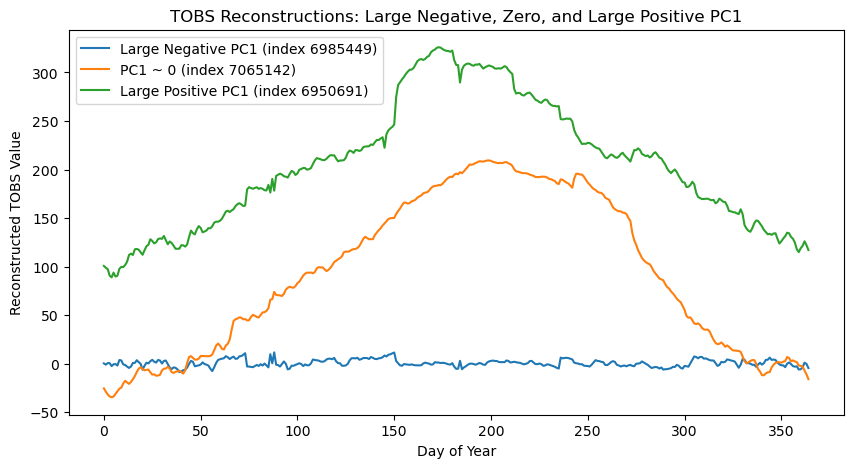

In [13]:
import matplotlib.pyplot as plt

# Filter to TOBS element
tobs_df = coefficients_df[coefficients_df['ELEMENT'] == 'TOBS'].copy()

# Ensure PC1 column exists (could also be named like 'PC1', 'PC_1', etc.—check)
pc1_col = None
for col in tobs_df.columns:
    if col.upper() in ["PC1", "PC_1", "PC 1"]:
        pc1_col = col
        break
if not pc1_col:
    raise ValueError(f"Could not find a PC1 column in {tobs_df.columns}")

# Get indices for large positive, close to zero, and large negative PC1 coefficients
quantiles = tobs_df[pc1_col].quantile([0.05, 0.5, 0.95])
neg_idx = (tobs_df[pc1_col] - quantiles.iloc[0]).abs().idxmin()
zero_idx = (tobs_df[pc1_col] - quantiles.iloc[1]).abs().idxmin()
pos_idx = (tobs_df[pc1_col] - quantiles.iloc[2]).abs().idxmin()
example_indices = [neg_idx, zero_idx, pos_idx]
example_labels = [
    f"Large Negative PC1 (index {neg_idx})",
    f"PC1 ~ 0 (index {zero_idx})",
    f"Large Positive PC1 (index {pos_idx})"
]
example_df = tobs_df.loc[example_indices]

# Reconstruct the measurements
pca = pca_results['TOBS']
components = pca['components']
mean = pca['mean']

def reconstruct_row(coeff_row, mean, components):
    pcs = []
    for i in range(components.shape[0]):
        comp_colnames = [f'PC{i+1}', f'PC_{i+1}', f'PC {i+1}']
        for col in comp_colnames:
            if col in coeff_row:
                pcs.append(coeff_row[col])
                break
        else:
            pcs.append(0)
    pcs = np.array(pcs)
    return mean + np.dot(pcs, components)

plt.figure(figsize=(10,5))
for i, (idx, coeff_row) in enumerate(example_df.iterrows()):
    reconstruction = reconstruct_row(coeff_row, mean, components)
    plt.plot(reconstruction, label=example_labels[i])
plt.xlabel('Day of Year')
plt.ylabel('Reconstructed TOBS Value')
plt.title('TOBS Reconstructions: Large Negative, Zero, and Large Positive PC1')
plt.legend()
plt.show()
